### Import libaries

In [0]:
import pandas as pd
import numpy as np 
import seaborn as sns 
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as ss

### Import data

In [0]:
# Read from url - Take time to run
url = "http://stat-computing.org/dataexpo/2009/2008.csv.bz2"
df = pd.read_csv(url, compression='bz2')

In [0]:
# Reduce rows
df = df.sample(frac=0.35)

In [4]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
6128384,2008,11,12,3,759.0,800,912.0,855,OO,7764,N299SW,73.0,55.0,53.0,17.0,-1.0,SLC,PIH,150,3.0,17.0,0,NaN,0,0.0,0.0,17.0,0.0,0.0
6149000,2008,11,22,6,1433.0,1435,1614.0,1618,UA,823,N929UA,101.0,103.0,73.0,-4.0,-2.0,BOS,IAD,413,9.0,19.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5778052,2008,10,11,6,1829.0,1835,2014.0,2009,NW,143,N344NW,105.0,94.0,70.0,5.0,-6.0,ORD,MSP,334,16.0,19.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5898219,2008,10,25,6,2055.0,2100,452.0,523,B6,90,N599JB,297.0,323.0,279.0,-31.0,-5.0,OAK,JFK,2576,5.0,13.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5788882,2008,10,14,2,831.0,835,1221.0,1212,NW,630,N364NB,170.0,157.0,144.0,9.0,-4.0,MEM,LGA,963,6.0,20.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


Variable descriptions: http://stat-computing.org/dataexpo/2009/the-data.html

Reference: https://www.kaggle.com/fabiendaniel/predicting-flight-delays-tutorial

### Data pre-processing

In [5]:
df.count()

Year                 2453405
Month                2453405
DayofMonth           2453405
DayOfWeek            2453405
DepTime              2405717
CRSDepTime           2453405
ArrTime              2400264
CRSArrTime           2453405
UniqueCarrier        2453405
FlightNum            2453405
TailNum              2424360
ActualElapsedTime    2399228
CRSElapsedTime       2453109
AirTime              2399228
ArrDelay             2399228
DepDelay             2405717
Origin               2453405
Dest                 2453405
Distance             2453405
TaxiIn               2400264
TaxiOut              2405404
Cancelled            2453405
CancellationCode       48139
Diverted             2453405
CarrierDelay          533520
WeatherDelay          533520
NASDelay              533520
SecurityDelay         533520
LateAircraftDelay     533520
dtype: int64

In [6]:
#Create Date column
#df['Date'] = pd.to_datetime(df[['Year', 'Month', 'DayofMonth']])

# Drop columns
# Year: The dataset only contains data in 2008
# Cancelled + CancellationCode + Diverted: Cancelled flight does not have delay label.
df.drop(['Year', 'Cancelled', 'CancellationCode', 'Diverted'], axis=1, inplace=True)
# Delay details: Only 20% rows have these features.
df.drop(['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], axis=1, inplace=True)
# Time: Only keep CRSArrTime, CRSElapsedTime
df.drop(['DepTime', 'ArrTime', 'CRSDepTime', 'ActualElapsedTime'], axis=1, inplace=True)
# Airport: Only keep the Dest Airport
df.drop(['Origin'], axis=1, inplace=True)
# Carrier: Drop FlightNum and TailNum
df.drop(['FlightNum', 'TailNum'], axis=1, inplace=True)

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df.count()

Month             2399227
DayofMonth        2399227
DayOfWeek         2399227
CRSArrTime        2399227
UniqueCarrier     2399227
CRSElapsedTime    2399227
AirTime           2399227
ArrDelay          2399227
DepDelay          2399227
Dest              2399227
Distance          2399227
TaxiIn            2399227
TaxiOut           2399227
dtype: int64

In [0]:
# Convert CRSArrTime to Parts of the Day
conditions = [
    (df['CRSArrTime'] >= 500) & (df['CRSArrTime'] < 1201),
    (df['CRSArrTime'] >= 1201) & (df['CRSArrTime'] < 1701),
    (df['CRSArrTime'] >= 1701) & (df['CRSArrTime'] < 2101)]
choices = [1, 2, 3]
df['PotD'] = np.select(conditions, choices, default=4)

# Morning, Afternoon, Evening, Night

In [0]:
# Convert Months to Quarter
conditions = [
    (df['Month'] >= 4) & (df['Month'] < 7),
    (df['Month'] >= 7) & (df['Month'] < 10),
    (df['Month'] >= 10)]
choices = [2, 3, 4]
df['Quarter'] = np.select(conditions, choices, default=1)

In [0]:
# Convert DayofMonth to Week
conditions = [
    (df['DayofMonth'] >= 8) & (df['DayofMonth'] < 15),
    (df['DayofMonth'] >= 15) & (df['DayofMonth'] < 22),
    (df['DayofMonth'] >= 22)]
choices = [2, 3, 4]
df['Week'] = np.select(conditions, choices, default=1)

In [0]:
# Convert DayOfWeek to Weekend
conditions = [
    (df['DayOfWeek'] >= 6)]
choices = [1]
df['Weekend'] = np.select(conditions, choices, default=0)

In [0]:
# Convert ArrDelay to Delay
# A flight only counts as late if it is more than 30 minutes late.
conditions = [
    (df['ArrDelay'] > 30)]
choices = [1]
df['Delay'] = np.select(conditions, choices, default=0)

In [12]:
df.drop(['Month', 'DayofMonth', 'DayOfWeek', 'CRSArrTime'], axis=1, inplace=True)
df.dtypes

UniqueCarrier      object
CRSElapsedTime    float64
AirTime           float64
ArrDelay          float64
DepDelay          float64
Dest               object
Distance            int64
TaxiIn            float64
TaxiOut           float64
PotD                int64
Quarter             int64
Week                int64
Weekend             int64
Delay               int64
dtype: object

In [13]:
df.head()

,UniqueCarrier,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Dest,Distance,TaxiIn,TaxiOut,PotD,Quarter,Week,Weekend,Delay
6128384,OO,55.0,53.0,17.0,-1.0,PIH,150,3.0,17.0,1,4,2,0,0
6149000,UA,103.0,73.0,-4.0,-2.0,IAD,413,9.0,19.0,2,4,4,1,0
5778052,NW,94.0,70.0,5.0,-6.0,MSP,334,16.0,19.0,3,4,2,1,0
5898219,B6,323.0,279.0,-31.0,-5.0,JFK,2576,5.0,13.0,1,4,4,1,0
5788882,NW,157.0,144.0,9.0,-4.0,LGA,963,6.0,20.0,2,4,2,0,0


### Data analysis

In [14]:
#Check basic stats
df.describe()

,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Quarter,Week,Weekend,Delay
count,2.399227e+06,2.399227e+06,2.399227e+06,2.399227e+06,2.399227e+06,2.399227e+06,2.399227e+06,2.399227e+06,2.399227e+06,2.399227e+06,2.399227e+06,2.399227e+06
mean,1.290501e+02,1.039973e+02,8.153807e+00,9.908924e+00,7.286413e+02,6.860998e+00,1.643666e+01,2.242809e+00,2.467077e+00,2.621516e+00,2.624145e-01,1.314365e-01
std,6.950736e+01,6.741273e+01,3.852117e+01,3.524080e+01,5.631948e+02,4.910244e+00,1.129912e+01,1.019444e+00,1.104508e+00,1.146640e+00,4.399468e-01,3.378772e-01
min,-1.410000e+02,0.000000e+00,-1.290000e+02,-9.200000e+01,2.400000e+01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+01,5.600000e+01,-1.000000e+01,-4.000000e+00,3.260000e+02,4.000000e+00,1.000000e+01,1.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
50%,1.110000e+02,8.600000e+01,-2.000000e+00,-1.000000e+00,5.810000e+02,6.000000e+00,1.400000e+01,2.000000e+00,2.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00
75%,1.590000e+02,1.320000e+02,1.200000e+01,8.000000e+00,9.540000e+02,8.000000e+00,1.900000e+01,3.000000e+00,3.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00
max,6.600000e+02,1.154000e+03,2.461000e+03,2.467000e+03,4.962000e+03,2.010000e+02,3.710000e+02,4.000000e+00,4.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00


In [15]:
#Check correlation
df.corr()

,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Quarter,Week,Weekend,Delay
CRSElapsedTime,1.000000,0.988089,0.012342,0.035338,0.983134,0.105353,0.142519,0.090756,-0.007524,0.001179,0.020742,0.030975
AirTime,0.988089,1.000000,0.034555,0.027301,0.982819,0.086145,0.107329,0.077379,-0.013972,0.000714,0.019022,0.041123
ArrDelay,0.012342,0.034555,1.000000,0.931346,0.006450,0.121907,0.321232,0.113933,-0.052561,0.003756,-0.006481,0.738395
DepDelay,0.035338,0.027301,0.931346,1.000000,0.026142,0.023610,0.100507,0.139606,-0.039913,0.005448,0.003914,0.684567
Distance,0.983134,0.982819,0.006450,0.026142,1.000000,0.078122,0.090640,0.090244,-0.006415,0.001199,0.022981,0.018897
TaxiIn,0.105353,0.086145,0.121907,0.023610,0.078122,1.000000,0.041534,-0.019328,0.002897,-0.002152,0.008783,0.087461
TaxiOut,0.142519,0.107329,0.321232,0.100507,0.090640,0.041534,1.000000,0.058041,-0.018896,-0.000257,-0.024008,0.289445
PotD,0.090756,0.077379,0.113933,0.139606,0.090244,-0.019328,0.058041,1.000000,-0.006537,-0.000118,-0.001961,0.133172
Quarter,-0.007524,-0.013972,-0.052561,-0.039913,-0.006415,0.002897,-0.018896,-0.006537,1.000000,-0.000041,-0.003344,-0.046620
Week,0.001179,0.000714,0.003756,0.005448,0.001199,-0.002152,-0.000257,-0.000118,-0.000041,1.000000,-0.003586,0.001298


In [16]:
# Groupby carrier
df.groupby(['UniqueCarrier']).mean()

,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Quarter,Week,Weekend,Delay
UniqueCarrier,,,,,,,,,,,,
9E,100.411040,71.205581,3.955167,6.592800,451.421674,8.500549,18.067277,2.188678,2.502004,2.618076,0.265571,0.105740
AA,167.657044,141.951191,12.470640,13.109786,1058.272225,8.228765,16.837942,2.322855,2.488592,2.627442,0.274017,0.170977
AQ,73.866318,60.414488,-3.442868,-1.966019,410.536594,3.879761,8.100075,2.100448,1.000000,2.622853,0.263256,0.016430
AS,154.929769,131.719498,4.995852,6.893895,960.042250,5.778053,15.534155,2.340977,2.473815,2.609687,0.269286,0.109812
B6,179.653794,150.005462,10.949745,12.595220,1098.243880,6.264074,21.738783,2.349986,2.465095,2.636011,0.282721,0.165826
CO,186.049211,155.491433,10.893585,13.048227,1151.821264,7.969931,20.433205,2.304460,2.444950,2.627264,0.254050,0.150861
DL,156.509052,127.140494,7.836570,7.910695,926.353573,8.682069,20.612364,2.248328,2.499820,2.614986,0.259326,0.118098
EV,95.647805,69.888983,10.268383,11.984665,443.882137,7.343727,16.698814,2.101415,2.498658,2.612037,0.261080,0.150260
F9,143.303356,121.604895,6.168353,5.980796,878.794966,7.384170,14.501848,2.327982,2.487642,2.618950,0.271006,0.091476


In [17]:
# Groupby destination airport
df.groupby(['Dest']).mean()

,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Quarter,Week,Weekend,Delay
Dest,,,,,,,,,,,,
ABE,100.958486,74.028083,9.810134,12.216728,538.803419,4.469475,20.054335,2.757631,2.570818,2.575092,0.227106,0.150794
ABI,53.378408,33.716467,9.617230,10.525627,158.000000,3.583424,15.170120,2.660851,2.516903,2.596510,0.260632,0.131952
ABQ,114.173070,92.307438,5.777903,8.798694,653.263398,5.337220,13.507621,2.277938,2.475592,2.615720,0.258622,0.105500
ABY,54.444751,27.831492,8.292818,8.906077,146.000000,3.558011,22.441989,2.591160,2.469613,2.651934,0.245856,0.135359
ACK,85.938776,45.503401,25.360544,20.823129,207.571429,5.884354,39.088435,2.108844,2.775510,2.598639,0.292517,0.299320
ACT,44.778963,23.568598,5.222561,6.489329,89.000000,4.797256,15.146341,2.280488,2.370427,2.618902,0.271341,0.102134
ACV,76.404104,56.286504,11.382794,11.303867,263.528019,4.449092,15.747435,2.462510,2.510655,2.678769,0.269929,0.153118
ACY,113.615385,87.333333,21.717949,18.897436,678.000000,3.666667,25.435897,2.974359,1.256410,2.333333,0.205128,0.179487
ADK,188.826087,169.695652,3.695652,4.826087,1192.000000,4.695652,13.304348,2.608696,2.565217,2.260870,0.391304,0.086957


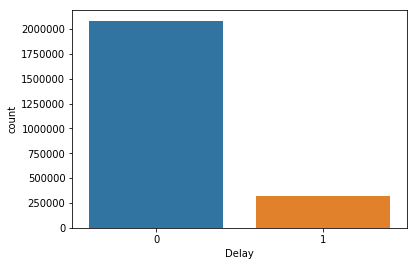

In [18]:
# Bias check
sns.countplot(x="Delay", data=df)

In [0]:
# Check Correlation
def cramers_corrected_stat(x, y):

    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result=-1
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:   
        conf_matrix=pd.crosstab(x, y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True

        chi2 = ss.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    return round(result,6)

#### Quarter

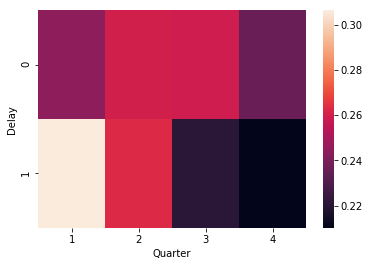

In [20]:
sns.boxplot(['Quarter'], ['ArrDelay'], data=df)

In [21]:
cramers_corrected_stat(df['Delay'], df['Quarter'])

0.052166

#### Week

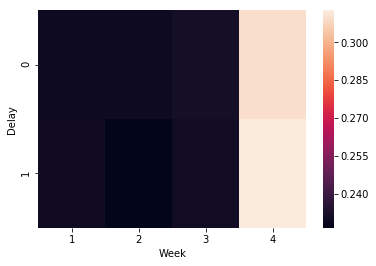

In [22]:
sns.heatmap(pd.crosstab(df['Delay'], df['Week'], normalize='index'))

In [23]:
cramers_corrected_stat(df['Delay'], df['Week'])

0.002538

#### Weekend

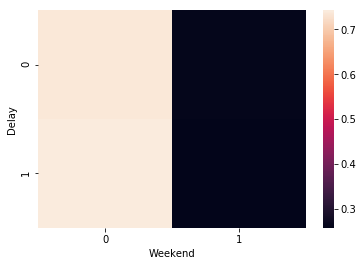

In [24]:
sns.heatmap(pd.crosstab(df['Delay'], df['Weekend'], normalize='index'))

In [25]:
cramers_corrected_stat(df['Delay'], df['Weekend'])

0.003953

#### Parts of the Day

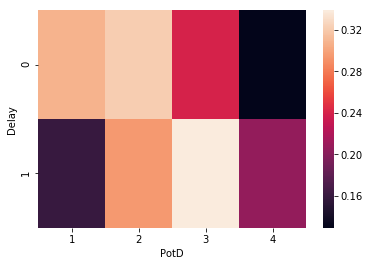

In [26]:
sns.heatmap(pd.crosstab(df['Delay'], df['PotD'], normalize='index'))

In [27]:
cramers_corrected_stat(df['Delay'], df['PotD'])

0.135213

### Encoding

In [0]:
# Apply One-hot encoding to Dest column

df = pd.concat([df, pd.get_dummies(df['Dest'], prefix='Dest',dummy_na=True)],axis=1).drop(['Dest'],axis=1)

In [29]:
# Apply One-hot encoding to UniqueCarrier column

df = pd.concat([df, pd.get_dummies(df['UniqueCarrier'], prefix='UniqueCarrier',dummy_na=True)],axis=1).drop(['UniqueCarrier'],axis=1)
df.head()

,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Quarter,Week,Weekend,Delay,UniqueCarrier_9E,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,UniqueCarrier_DL,UniqueCarrier_EV,UniqueCarrier_F9,UniqueCarrier_FL,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV,UniqueCarrier_nan
6128384,55.0,53.0,17.0,-1.0,150,3.0,17.0,1,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6149000,103.0,73.0,-4.0,-2.0,413,9.0,19.0,2,4,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5778052,94.0,70.0,5.0,-6.0,334,16.0,19.0,3,4,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5898219,323.0,279.0,-31.0,-5.0,2576,5.0,13.0,1,4,4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5788882,157.0,144.0,9.0,-4.0,963,6.0,20.0,2,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [0]:
# http://www.insightsbot.com/blog/McTKK/python-one-hot-encoding-with-scikit-learn
#from sklearn.preprocessing import LabelBinarizer

#UniqueCarrier_lb = LabelBinarizer()
#X = UniqueCarrier_lb.fit_transform(df.UniqueCarrier.values)

### Model evaluation

In [0]:
#features = df.drop(['Delay'], axis=1)
# Why?
# Airline:
# Dest Airport + CRSArrTime: 
# Departure features:


X_data = df.drop(['Delay'], axis=1)
y_data = df['Delay']

# Holdout
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

In [32]:
X_train.head()

,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Quarter,Week,Weekend,UniqueCarrier_9E,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,UniqueCarrier_DL,UniqueCarrier_EV,UniqueCarrier_F9,UniqueCarrier_FL,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV,UniqueCarrier_nan
444631,229.0,190.0,119.0,113.0,1750,12.0,33.0,4,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1089329,240.0,217.0,23.0,25.0,1576,4.0,17.0,4,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
228158,93.0,79.0,-2.0,-4.0,533,4.0,12.0,3,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5215890,125.0,112.0,2.0,-2.0,738,6.0,11.0,2,3,4,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
866029,72.0,45.0,-3.0,-2.0,256,3.0,23.0,3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


#### Naive Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [34]:
# Metrics
# https://medium.com/thalus-ai/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b
# Confusion Matrix
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

[[391506  25147]
 [  2036  61157]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.97    416653
           1       0.71      0.97      0.82     63193

    accuracy                           0.94    479846
   macro avg       0.85      0.95      0.89    479846
weighted avg       0.96      0.94      0.95    479846



#### SVC

In [0]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [0]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

#### Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X, y)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [0]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

#### Ensemble learning
https://medium.com/@aravanshad/gradient-boosting-versus-random-forest-cfa3fa8f0d80

### PCA

In [0]:
#Standar Scaler

from sklearn.preprocessing import StandardScaler

# Fit on training set only.
scaler = StandardScaler().fit(X_train)
    
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
#PCA
from sklearn.decomposition import PCA

# Fit on training set only.
pca = PCA(n_components=1).fit(X_train)

# Apply transform to both the training set and the test set.
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# TODO

1. Edit threshhold / class weight
2. PCA: Dimension reducing
3. RFE: Features selection
4. GridsearchCV for tuning
- Tuning with 3 values
- Goal: Precison ~ Recall
5. Compare performances among models

#### Note
- Label Encoder: For algorithm that does not care about distance between data point (Naive Bayes, ...)